## Imports

In [1]:
import pathlib
import sys
import urllib.request

import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d
import pandas as pd
import tifffile
from mpl_toolkits.mplot3d import Axes3D

sys.path.append(str("../utils/"))
import trimesh
from microscope_pointcloud import MicroscopeVolumeToPointCloud
from skimage.measure import marching_cubes

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Load a volume as a test

In [2]:
# load a volume as a test
nuclei_volume_path = pathlib.Path(
    "/home/lippincm/mnt/bandicoot/NF1_organoid_data/data/NF0014_T1/zstack_images/C4-2/C4-2_405.tif"
).resolve(strict=True)
nuclei_mask_path = pathlib.Path(
    "/home/lippincm/mnt/bandicoot/NF1_organoid_data/data/NF0014_T1/segmentation_masks/C4-2/nuclei_masks.tiff"
).resolve(strict=True)
volume = tifffile.imread(nuclei_volume_path)
mask = tifffile.imread(nuclei_mask_path)

# only keep masked region
# volume[mask==0] = 0

## Point cloud conversion


In [3]:
checkpoint_url = "https://cloud.tsinghua.edu.cn/f/202b29805eea45d7be92/?dl=1"
checkpoint_path = pathlib.Path("../models/point_bert.pth").resolve()
if not checkpoint_path.exists():
    checkpoint_path.parent.mkdir(parents=True, exist_ok=True)
    urllib.request.urlretrieve(checkpoint_url, str(checkpoint_path))

## Selection of number of points
Default is 2048 points for PointBert
We can increase this to 8192*4 = 32768 points for better representation of complex structures and intensity variations.
We could scale down to increase speed, but we lose detail.
Options that we could try:
- 2_048
- 8_192
- 16_384
- 32_768
- 65_536
- 131_072
- 262_144
- 524_288
- 1_048_576
- 2_097_152
- 4_194_304
- 8_388_608
- 16_777_216


For a nucleus with a diameter of ~10 microns, at 0.1 micron (XY) and 1 micron Z resolution, that's 100^3 = 100,000 voxels.
| Structure | Diameter (um) | Resolution (Z, Y, X) (um) | Voxels | 
|-----------|------------|--------|--------|
| Nucleus (Anisotropic) | 10 | 1, 0.1, 0.1 | 100,000 |
| Nucleus (Isotropic) | 10 | 0.1, 0.1, 0.1 | 1,000,000 |
| Small Cell (Anisotropic) | 50 | 1, 0.1, 0.1 | 500,000 |
| Small Cell (Isotropic) | 50 | 0.1, 0.1, 0.1 | 125,000,000 |
| Large Cell (Anisotropic) | 100 | 1, 0.1, 0.1 | 2,000,000 |
| Large Cell (Isotropic) | 100 | 0.1, 0.1, 0.1 | 1,000,000,000 |

The number of points should sample the structure well enough to capture its geometry and intensity variations.
For the Large Cell (Isotropic) with 1 billion voxels, we might need several million points to represent it accurately. This could be computationally expensive.
A practical approach would be to start with 32,768 or 65,536 points and

In [4]:
number_of_points = 524_288

In [5]:
# Create converter
converter = MicroscopeVolumeToPointCloud(
    target_points=number_of_points,
    voxel_size=(1, 0.1, 0.1),  # z, y, x in micrometers
    intensity_threshold=None,  # Auto Otsu
)
point_cloud = converter.convert(volume, mask=mask)  # Shape: (2048, 3)
print(point_cloud.keys())  # dict_keys(['points', 'intensities'])
print(point_cloud["points"].shape)

dict_keys(['coords', 'features', 'points'])
(524288, 5)


In [6]:
point_cloud["features"]

array([[-0.28364964, -0.29415246],
       [ 0.5341594 ,  0.52610963],
       [-0.04034896,  0.7467517 ],
       ...,
       [ 0.14517715, -0.57421699],
       [-0.53940174, -0.40918062],
       [-1.52007532,  1.03189268]])

In [7]:
# save the point cloud
output_pcd_path = pathlib.Path("../point_clouds/C4-2_point_cloud.parquet").resolve()
output_pcd_path.parent.mkdir(parents=True, exist_ok=True)
point_cloud_df = pd.DataFrame(
    {
        "x_points": point_cloud["points"][:, 0],
        "y_points": point_cloud["points"][:, 1],
        "z_points": point_cloud["points"][:, 2],
        "feature_1": point_cloud["features"][:, 0],
        "feature_2": point_cloud["features"][:, 1],
        "x_coords": point_cloud["coords"][:, 0],
        "y_coords": point_cloud["coords"][:, 1],
        "z_coords": point_cloud["coords"][:, 2],
    }
)
point_cloud_df.to_parquet(output_pcd_path, index=False)

The five columns in point_cloud['points'] are: z, y, x, intensity, density (local or global based on settings)

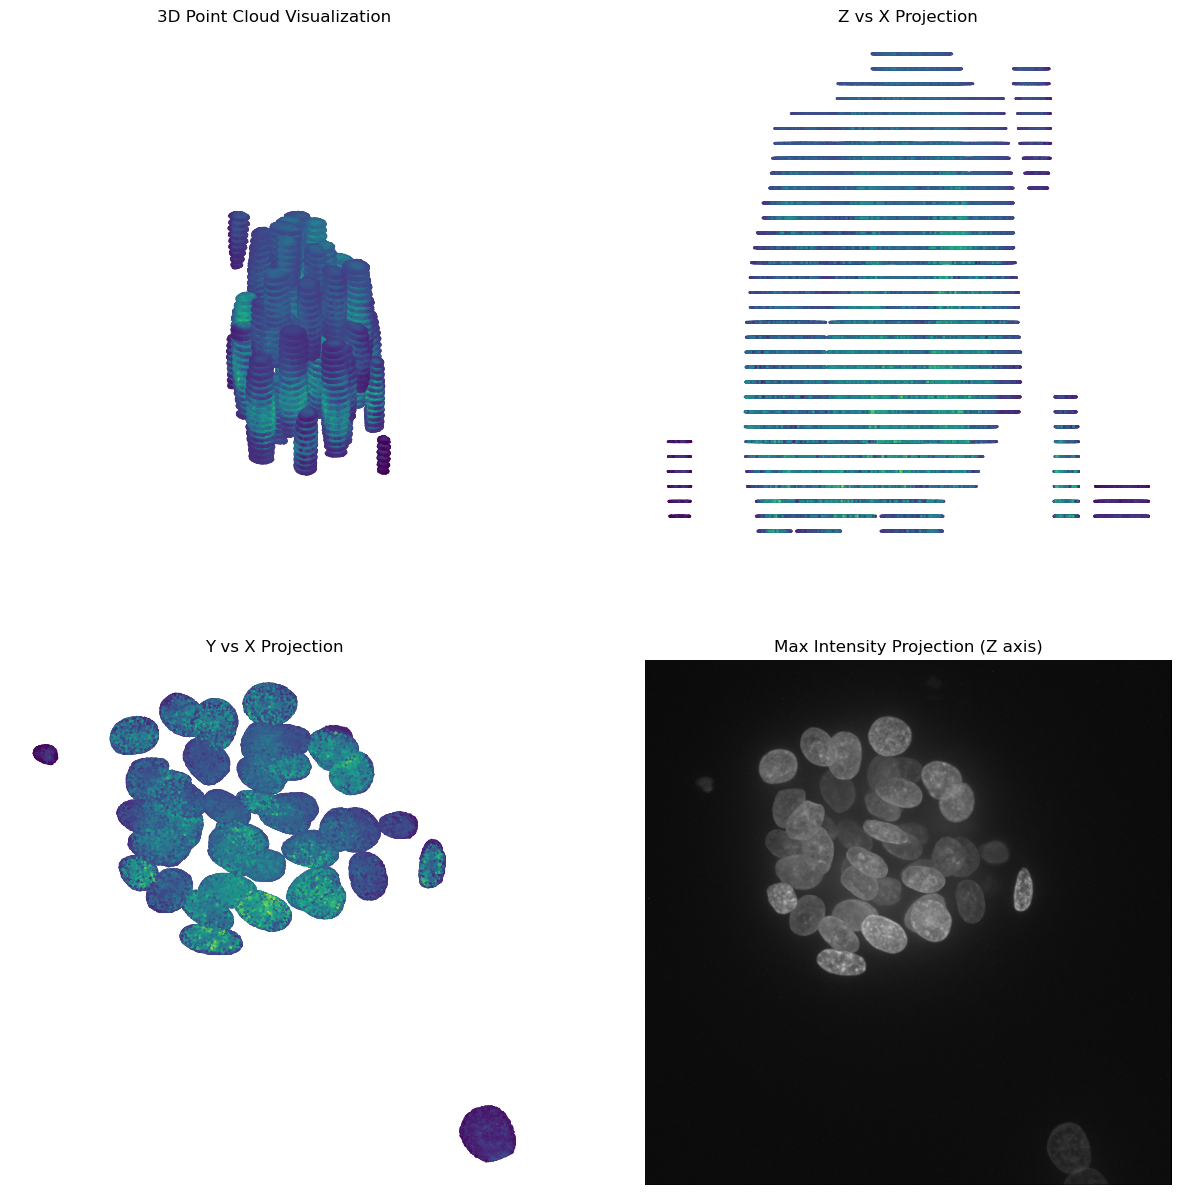

In [8]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(221, projection="3d")
ax.scatter(
    point_cloud["points"][:, 2],  # X
    point_cloud["points"][:, 1],  # Y
    point_cloud["points"][:, 0],  # z
    c=point_cloud["points"][:, 3],
    cmap="viridis",
    s=1,
)

ax.title.set_text("3D Point Cloud Visualization")
ax.invert_yaxis()
ax.axis("off")


ax = fig.add_subplot(222)
ax.scatter(
    point_cloud["points"][:, 2],  # X
    point_cloud["points"][:, 0],  # Z
    c=point_cloud["points"][:, 3],
    cmap="viridis",
    s=1,
)

ax.title.set_text("Z vs X Projection")
ax.axis("off")

ax = fig.add_subplot(223)
ax.scatter(
    point_cloud["points"][:, 2],  # x
    point_cloud["points"][:, 1],  # y
    c=point_cloud["points"][:, 3],
    cmap="viridis",
    s=1,
)

ax.set_title("Y vs X Projection")
ax.invert_yaxis()


ax.axis("off")
ax = fig.add_subplot(224)
ax.imshow(np.max(volume, axis=0), cmap="gray")
ax.set_title("Max Intensity Projection (Z axis)")
# turn axis ticks off
ax.axis("off")

plt.show()